# Help Twitter Combat Hate Speech Using NLP and Machine Learning

## Table of Contents
### 1 - Import Libraries and Load Data
### 2 - Text Cleaning
##### 2.1 - Handle Diacritics using Text Normalization
##### 2.2 - Remove user handles
##### 2.3 - Remove the URLs
##### 2.4 - Tokenize using TweetTokenizer
##### 2.5 - Remove Stopwords
##### 2.6 - Spelling Corrections
##### 2.7 - Remove #symbols while retaining the text
##### 2.8 - Remove single and double character length tokens
##### 2.9 - Remove digits
##### 2.10 - Remove non alpha numeric characters

### 3 - Exploratory Data Analysis
##### 3.1 - Check for data imbalance
##### 3.2 - Check top terms in the tweet

### 4 - Predictive Modeling
##### 4.1 - Data Formatting for Predidictive Modeling
##### 4.2 - Using tf-idf vectorizer to generate the feature vectors
##### 4.3 - Model using Ordinary Logistic Regression with Default Parameters
##### 4.4 - Model Evaluation
##### 4.5 - Model using Weighted Logistic Regression to handle data imbalance
##### 4.6 - Model Fine Tuning using Randomized Grid Search
##### 4.7 - Fine Tuned Model Prediction & Evaluation with balanced class weights
##### 4.8 - Fine Tuned Model Prediction & Evaluation with imbalanced class weights

### 5 - Summary

### 1. Import Libraries and Load Data

In [1]:
#general packages for data manipulation
import os
import pandas as pd
import numpy as np
#visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#consistent sized plot 
from pylab import rcParams
rcParams['figure.figsize']=12,5
rcParams['axes.labelsize']=12
rcParams['xtick.labelsize']=12
rcParams['ytick.labelsize']=12
#handle the warnings in the code
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)
#text preprocessing libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

import re
#display pandas dataframe columns 
pd.options.display.max_columns = None

In [2]:
#load the csv file as a pandas dataframe

tweet = pd.read_csv('data/TwitterHate.csv',delimiter=',',engine='python',encoding='utf-8-sig')
tweet.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
#get rid of the identifier number of the tweet
tweet.drop('id',axis=1,inplace=True)

In [4]:
#view one of the tweets randomly 
random = np.random.randint(0,len(tweet))
print(random)
tweet.iloc[random]['tweet']

21067


"can't wait for this! skyrim special edition trailer - e3 2016 bethesda press conference @user   "

In [5]:
#create a copy of the original data to work with 
df = tweet.copy()

### 2. Text Cleaning

##### 2.1 Handle Diacritics using text normalization

In [6]:
def simplify(text):
    '''Function to handle the diacritics in the text'''
    import unicodedata
    try:
        text = unicode(text, 'utf-8')
    except NameError:
        pass
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return str(text)


In [7]:
df['tweet'] = df['tweet'].apply(simplify)

##### 2.2 Remove user handles

In [8]:
#test on a sample string
sample = "and @user1 i would like you to discuss with @user2 and then with @username3"
pattern = re.compile(r'@\w+')
re.findall(pattern,sample)

['@user1', '@user2', '@username3']

In [9]:
#remove all the user handles --> strings starting with @
df['tweet'].replace(r'@\w+','',regex=True,inplace=True)

##### 2.3 Remove the urls

In [10]:
#test on a sample 
sample = "https://www.machinelearing.com prakhar and https://www.simple.com"
pattern = re.compile(r'http\S+')
re.findall(pattern,sample)

['https://www.machinelearing.com', 'https://www.simple.com']

In [11]:
df['tweet'].replace(r'http\S+','',regex=True,inplace=True)

##### 2.4 Tokenize using tweet tokenizer

In [12]:
#test on a sample text
sample = 'wonderfl :-)  when are you coming for #party'
tweet_tokenize = TweetTokenizer(preserve_case=True)
tweet_tokenize.tokenize(sample)

['wonderfl', ':-)', 'when', 'are', 'you', 'coming', 'for', '#party']

In [13]:
#tokenize the tweets in the dataframe using TweetTokenizer
tokenizer = TweetTokenizer(preserve_case=True)
df['tweet'] = df['tweet'].apply(tokenizer.tokenize)

In [14]:
#view the tokenized tweets
df.head(3)

,label,tweet
0,0,"[when, a, father, is, dysfunctional, and, is, ..."
1,0,"[thanks, for, #lyft, credit, i, can't, use, ca..."
2,0,"[bihday, your, majesty]"


##### 2.5 Remove Stopwords

Append more words to be removed from the text - example rt and amp which occur very frequently

In [15]:
stop_words = stopwords.words('english')

#add additional stop words to be removed from the text
additional_list = ['amp','rt','u',"can't",'ur']

for words in additional_list:
    stop_words.append(words)

In [16]:
stop_words[-10:]

["weren't",
 'won',
 "won't",
 'wouldn',
 "wouldn't",
 'amp',
 'rt',
 'u',
 "can't",
 'ur']

In [17]:
#remove stop words
def remove_stopwords(text):
    '''Function to remove the stop words from the text corpus'''
    clean_text = [word for word in text if not word in stop_words]
    return clean_text    

In [18]:
#remove the stop words from the tweets
df['tweet'] = df['tweet'].apply(remove_stopwords)

In [19]:
df['tweet'].head()

0    [father, dysfunctional, selfish, drags, kids, ...
1    [thanks, #lyft, credit, use, cause, offer, whe...
2                                    [bihday, majesty]
3                  [#model, love, take, time, !, !, !]
4                [factsguide, :, society, #motivation]
Name: tweet, dtype: object

##### 2.6 Spelling corrections

In [20]:
#apply spelling correction on a sample text
from textblob import TextBlob
sample = 'amazng man you did it finallyy'
txtblob = TextBlob(sample)
corrected_text = txtblob.correct()
print(corrected_text)

amazing man you did it finally


In [21]:
#textblob expect a string to be passed and not a list of strings
from textblob import TextBlob

def spell_check(text):
    '''Function to do spelling correction using '''
    txtblob = TextBlob(text)
    corrected_text = txtblob.correct()
    return corrected_text

##### 2.7 Remove # symbols while retaining the text

In [22]:
#try tremoving # symbols from a sample text
sample = '#winner #machine i am learning'
pattern = re.compile(r'#')
re.sub(pattern,'',sample)

'winner machine i am learning'

In [23]:
def remove_hashsymbols(text):
    '''Function to remove the hashtag symbol from the text'''
    pattern = re.compile(r'#')
    text = ' '.join(text)
    clean_text = re.sub(pattern,'',text)
    return tokenizer.tokenize(clean_text)    

In [24]:
df['tweet'] = df['tweet'].apply(remove_hashsymbols)

In [25]:
df.head(3)

,label,tweet
0,0,"[father, dysfunctional, selfish, drags, kids, ..."
1,0,"[thanks, lyft, credit, use, cause, offer, whee..."
2,0,"[bihday, majesty]"


##### 2.8 Remove single and double length characters

In [26]:
def rem_shortwords(text):
    '''Function to remove the short words of length 1 and 2 characters'''
    '''Arguments: 
       text: string
       returns: string without containing words of length 1 and 2'''
    lengths = [1,2]
    new_text = ' '.join(text)
    for word in text:
        text = [word for word in tokenizer.tokenize(new_text) if not len(word) in lengths]
        
    return new_text 

In [27]:
df['tweet'] = df['tweet'].apply(rem_shortwords)

In [28]:
df.head(2)

,label,tweet
0,0,father dysfunctional selfish drags kids dysfun...
1,0,thanks lyft credit use cause offer wheelchair ...


In [29]:
df['tweet'] = df['tweet'].apply(tokenizer.tokenize)

In [30]:
df.head(3)

,label,tweet
0,0,"[father, dysfunctional, selfish, drags, kids, ..."
1,0,"[thanks, lyft, credit, use, cause, offer, whee..."
2,0,"[bihday, majesty]"


##### 2.9 Remove digits

In [31]:
def rem_digits(text):
    '''Function to remove the digits from the list of strings'''
    no_digits = []
    for word in text:
        no_digits.append(re.sub(r'\d','',word))
    return ' '.join(no_digits)   

In [32]:
df['tweet'] = df['tweet'].apply(rem_digits)

In [33]:
df['tweet'] = df['tweet'].apply(tokenizer.tokenize)

In [34]:
df.head()

,label,tweet
0,0,"[father, dysfunctional, selfish, drags, kids, ..."
1,0,"[thanks, lyft, credit, use, cause, offer, whee..."
2,0,"[bihday, majesty]"
3,0,"[model, love, take, time, !, !, !]"
4,0,"[factsguide, :, society, motivation]"


##### 2.10 Remove special characters

In [35]:
def rem_nonalpha(text):
    '''Function to remove the non-alphanumeric characters from the text'''
    text = [word for word in text if word.isalpha()]
    return text

In [36]:
#remove the non alpha numeric characters from the tweet tokens
df['tweet'] = df['tweet'].apply(rem_nonalpha)

In [37]:
df['label'].value_counts()

label
0    29720
1     2242
Name: count, dtype: int64

### 3. Exploratory Data Analysis - Broad Approach

##### 3.1 Check for data balance

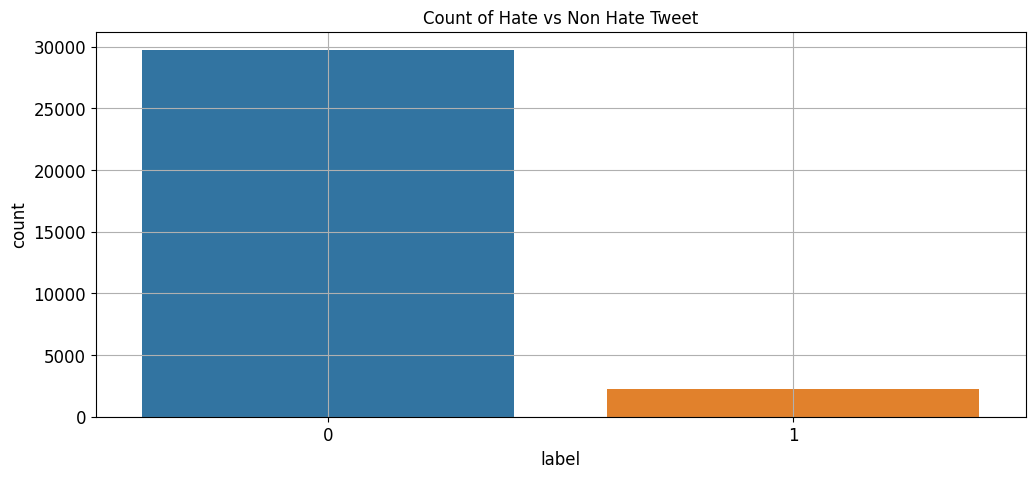

In [38]:
#plot of the count of hate and non hate tweet
sns.countplot(x=df["label"])
plt.title('Count of Hate vs Non Hate Tweet')
plt.grid()
plt.show()

There are more non hatespeeches than the hatespeech in the dataset

#### 3.2 Check out the top terms in the tweets

In [39]:
from collections import Counter
results = Counter()
df['tweet'].apply(results.update)
#print the top 10 most common terms in the tweet 
print(results.most_common(10))

[('love', 2762), ('day', 2319), ('happy', 1679), ('like', 1160), ('time', 1138), ('life', 1124), ('today', 1017), ('new', 994), ('thankful', 947), ('positive', 931)]


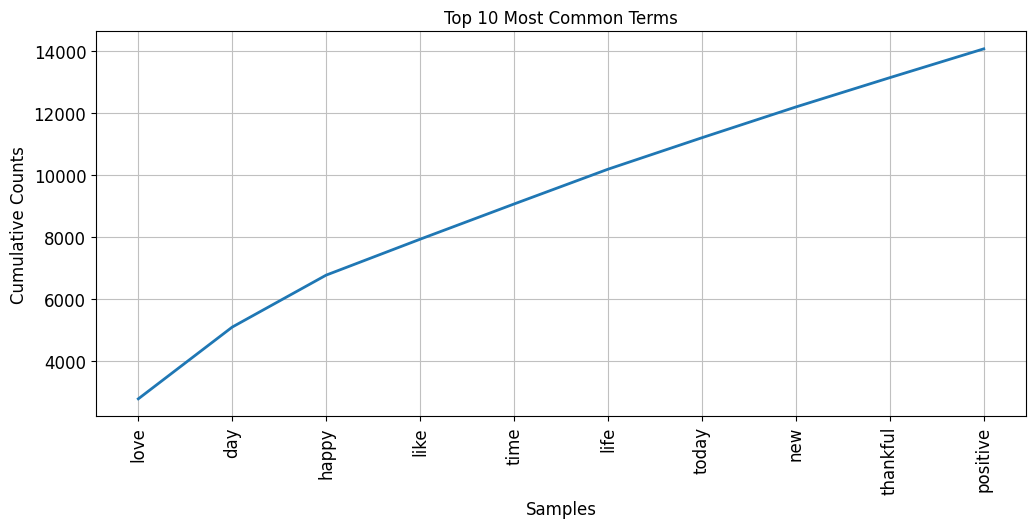

In [40]:
#plot the cumulative frequency of the top 10 most common tokens 
frequency = nltk.FreqDist(results)
plt.title('Top 10 Most Common Terms')
frequency.plot(10,cumulative=True)
plt.show()

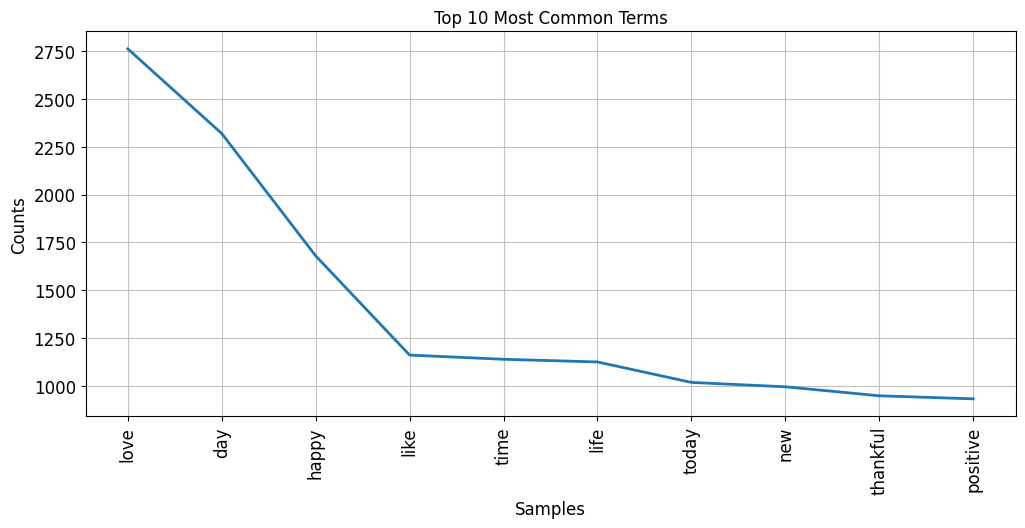

In [41]:
#plot the frequency of the top 10 most common tokens 
frequency = nltk.FreqDist(results)
plt.title('Top 10 Most Common Terms')
frequency.plot(10,cumulative=False)
plt.show()

Love is the most frequently used word followed by day, happy etc. This is expected as there are more non hate tweets than hate tweets in the dataset

### 4. Predictive Modeling
##### 4.1 Data Formatting for Predictive Modeling

In [42]:
df.head()

,label,tweet
0,0,"[father, dysfunctional, selfish, drags, kids, ..."
1,0,"[thanks, lyft, credit, use, cause, offer, whee..."
2,0,"[bihday, majesty]"
3,0,"[model, love, take, time]"
4,0,"[factsguide, society, motivation]"


In [43]:
#check for the null values
df.isnull().sum()

label    0
tweet    0
dtype: int64

In [44]:
#join the tokens back to form the string
df['tweet'] = df['tweet'].apply(lambda x: ' '.join(x))

In [45]:
#check the top rows
df.head(3)

,label,tweet
0,0,father dysfunctional selfish drags kids dysfun...
1,0,thanks lyft credit use cause offer wheelchair ...
2,0,bihday majesty


In [46]:
#split the data into input X and output y
X = df['tweet']
y = df['label']

In [47]:
#split the data 
from sklearn.model_selection import train_test_split
seed = 51
test_size = 0.2 #20% of the data in the 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=seed,stratify=df['label'])
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(25569,) (6393,) (25569,) (6393,)


##### 4.2 Use tf-idf as a feature to get into the vector space model

In [48]:
#import tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [49]:
#instantiate the vectorizer 
vectorizer = TfidfVectorizer(max_features=5000)

In [50]:
#fit on the training data
X_train = vectorizer.fit_transform(X_train)
#transform the test data
X_test = vectorizer.transform(X_test)

In [51]:
#check the shape
X_train.shape, X_test.shape

((25569, 5000), (6393, 5000))

##### 4.3 Model building: Ordinary Logistic Regression

In [52]:
#import the models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [53]:
#instantiate the models with default hyper-parameters
clf = LogisticRegression()
clf.fit(X_train,y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

##### 4.4 Model evaluation

In [54]:
#import the metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [55]:
#get the model accuracy on the training and the test set
print('Accuracy Score on training set %.5f' %accuracy_score(y_train,train_predictions))
print('Accuracy Score on test set %.5f' %accuracy_score(y_test,test_predictions))

Accuracy Score on training set 0.95569
Accuracy Score on test set 0.94791


Accuracy is never a good metric for an imbalanced dataset as in this case. This can be highighted using the f1 score. A low f1-score for a label indicate poor performance of the model.

In [56]:
print('Classification Report Training set')
print('\n')
print(classification_report(y_train,train_predictions))

Classification Report Training set


              precision    recall  f1-score   support

           0       0.96      1.00      0.98     23775
           1       0.95      0.39      0.55      1794

    accuracy                           0.96     25569
   macro avg       0.95      0.69      0.76     25569
weighted avg       0.96      0.96      0.95     25569



In [57]:
print('Classification Report Testing set')
print('\n')
print(classification_report(y_test,test_predictions))

Classification Report Testing set


              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5945
           1       0.90      0.29      0.44       448

    accuracy                           0.95      6393
   macro avg       0.93      0.64      0.70      6393
weighted avg       0.95      0.95      0.94      6393



The model's f1-score is low for label 1 which indicates the hate text in the twitter

##### 4.5 Weighted Logistic Regression Or Cost Sensitive Logistic Regression

In [58]:
df['label'].value_counts()

label
0    29720
1     2242
Name: count, dtype: int64

The minority to majority class ratio is 1:13

In [59]:
#define the weight of the class labels using inverse ratio
weights = {0:1.0,1:13.0}

#instantiate the logistic regression model and account for the weights to be applied for model coefficients update magnitude
clf = LogisticRegression(solver='lbfgs',class_weight=weights)

#fit and predict
clf.fit(X_train,y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

#classification report
print('Classification Report Training set')
print('------------------------------------')
print('\n')
print(classification_report(y_train,train_predictions))
print('\n')

print('Classification Report Testing set')
print('------------------------------------')
print('\n')
print(classification_report(y_test,test_predictions))

Classification Report Training set
------------------------------------


              precision    recall  f1-score   support

           0       1.00      0.95      0.97     23775
           1       0.60      0.98      0.74      1794

    accuracy                           0.95     25569
   macro avg       0.80      0.96      0.86     25569
weighted avg       0.97      0.95      0.96     25569



Classification Report Testing set
------------------------------------


              precision    recall  f1-score   support

           0       0.98      0.94      0.96      5945
           1       0.48      0.75      0.58       448

    accuracy                           0.92      6393
   macro avg       0.73      0.84      0.77      6393
weighted avg       0.94      0.92      0.93      6393



The f1 score of both the training and testing set has improved compared to the plain vanilla Logistic Regression model. There is still more opportunity to improve the score using better models or even handling the data imbalance by adding synthetic data

##### 4.6 Regularization and Hyperparameter tuning:

In [60]:
#import the required libraries for grid search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [61]:
# define search space
from scipy.stats import loguniform
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)

In [62]:
#check the search space 
print(space)

{'solver': ['newton-cg', 'lbfgs', 'liblinear'], 'penalty': ['l1', 'l2', 'elasticnet'], 'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2897434c0>}


##### 4.7 Fine tuned Model with Balanced Class Weights

In [63]:
#define the model with balanced class weights
weights = {0:1.0,1:1.0}
clf = LogisticRegression(class_weight=weights)
#define the number of folds 
folds = StratifiedKFold(n_splits=4,random_state=seed,shuffle=True)
# define search
grid_search = RandomizedSearchCV(estimator=clf,param_distributions=space, n_iter=100, scoring='recall',
                            n_jobs=-1, cv=folds, random_state=seed)
#fit grid search on the train data
grid_result = grid_search.fit(X_train,y_train)

/Users/jigishap/.pyenv/versions/3.10.6/envs/NLP_senti/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jigishap/.pyenv/versions/3.10.6/envs/NLP_senti/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jigishap/.pyenv/versions/3.10.6/envs/NLP_senti/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
248 fits failed out of a total of 400.
The score on these train-test partitions for thes

In [64]:
#retrieve the best model 
grid_result.best_estimator_

LogisticRegression(C=23.871926754399514, class_weight={0: 1.0, 1: 1.0},
                   penalty='l1', solver='liblinear')

In [65]:
#instantiate the best model
clf = LogisticRegression(C=23.871926754399514,penalty='l1',solver='liblinear',class_weight=weights)

In [66]:
#fit and predict
clf.fit(X_train,y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

#classification report
print('Classification Report Training set')
print('------------------------------------')
print('\n')
print(classification_report(y_train,train_predictions))
print('\n')

print('Classification Report Testing set')
print('------------------------------------')
print('\n')
print(classification_report(y_test,test_predictions))

Classification Report Training set
------------------------------------


              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23775
           1       0.98      0.93      0.95      1794

    accuracy                           0.99     25569
   macro avg       0.99      0.96      0.97     25569
weighted avg       0.99      0.99      0.99     25569



Classification Report Testing set
------------------------------------


              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5945
           1       0.62      0.56      0.59       448

    accuracy                           0.94      6393
   macro avg       0.79      0.77      0.78      6393
weighted avg       0.94      0.94      0.94      6393



##### 4.8 Fine tuned model with class weights proportional to the class imbalance

In [67]:
#use the class weights to handle the imbalance in the labels
weights = {0:1.0,1:13}

clf = LogisticRegression(class_weight=weights)
#define the number of folds 
folds = StratifiedKFold(n_splits=4,random_state=seed,shuffle=True )
# define search
grid_search = RandomizedSearchCV(estimator=clf,param_distributions=space, n_iter=100, scoring='recall',
                            n_jobs=-1, cv=folds, random_state=seed)
#fit grid search on the train data
grid_result = grid_search.fit(X_train,y_train)

#retrieve the best model 
grid_result.best_estimator_

/Users/jigishap/.pyenv/versions/3.10.6/envs/NLP_senti/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jigishap/.pyenv/versions/3.10.6/envs/NLP_senti/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

LogisticRegression(C=0.16731783677034165, class_weight={0: 1.0, 1: 13},
                   solver='liblinear')

In [68]:
#instantiate the best model
clf = LogisticRegression(C=0.16731783677034165,penalty='l2',solver='liblinear',class_weight=weights)

#fit and predict
clf.fit(X_train,y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

#classification report
print('Classification Report Training set')
print('------------------------------------')
print('\n')
print(classification_report(y_train,train_predictions))
print('\n')

print('Classification Report Testing set')
print('------------------------------------')
print('\n')
print(classification_report(y_test,test_predictions))

Classification Report Training set
------------------------------------


              precision    recall  f1-score   support

           0       0.99      0.94      0.97     23775
           1       0.53      0.93      0.68      1794

    accuracy                           0.94     25569
   macro avg       0.76      0.93      0.82     25569
weighted avg       0.96      0.94      0.95     25569



Classification Report Testing set
------------------------------------


              precision    recall  f1-score   support

           0       0.98      0.93      0.96      5945
           1       0.46      0.77      0.58       448

    accuracy                           0.92      6393
   macro avg       0.72      0.85      0.77      6393
weighted avg       0.95      0.92      0.93      6393



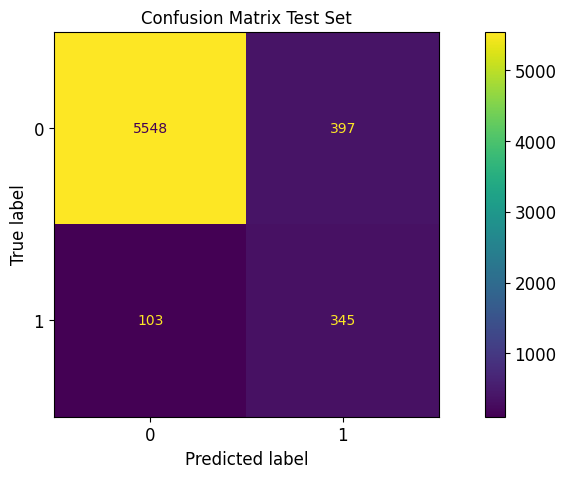

In [69]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, test_predictions, labels=clf.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.title('Confusion Matrix Test Set')
plt.show()

### 5. Summary
1. Logistic Regression with default paramaters recall = 29%
2. Logistic Regression with class weights in proportion to the data imbalance recall = 75%
3. Logistic Regression fine tuned with grid search and balanced class weights recall = 56%
4. Logistic Regression fine tuned with grid search and class weights in proportion to data imbalance recall = 77%